# CrSpEE Inspection Demo

This notebook contains several independent scripts that show how to load and visualize the dataset stats and annotated images:
- Section 1 shows the dataset stats
- Section 2 shows CrSpEE images along with their segmentation masks

But first we need to load the annotations and some python libraries:

In [7]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab
from torchvision.ops import masks_to_boxes
import torch

dataset_path = 'CrSpEE'
anns_file_path = os.path.join(dataset_path, 'training.json')
coco=COCO(anns_file_path)

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
for cat_it in categories:
    cat_names.append(cat_it['name'])


print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
Number of categories: 2
Number of annotations: 2287
Number of images: 1978


## 1.  Dataset statistics

This shows the number of annotations per category:

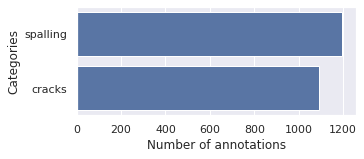

In [8]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,2))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

# fig = plot_1.get_figure()
# fig.savefig("output.png")

## 2. Visualize Annotated Images

For simplicity, to select and show the dataset images with the respective masks, we make use of the COCO API.
The script below shows how to load and visualize an image with all its annotations.

Unfortunately, several python libraries do not take into account the EXIF orientation tag, thus we have to explicitly rotate the images. Alternatively you can use instead OpenCV.

In [9]:
hotencode_cats = {0:'healthy', 1:'cracks', 2:'spalling'}

In [10]:
def load_image_id(image_name):
    img_id = -1
    for img_info in imgs:
        if img_info['file_name'] == image_name:
            image_id = img_info['id']
    
    return image_id

def load_image_anns(image_id):
    image_anns = []
    for anns_info in anns:
        if anns_info['image_id'] == image_id:
            image_anns.append(anns_info)
    
    return image_anns

In [11]:

def plot_ims_anns(img_list, subfolder, dataset_path):

    for image_filepath in img_list:
        image_filepath = image_filepath['file_name']
        # Obtain Exif orientation tag code
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break

        # Find image id
        img_id = -1
        for img in imgs:
            if img['file_name'] == image_filepath:
                img_id = img['id']
                break

        # Show image and corresponding annotations
        if img_id == -1:
            print('Incorrect file name')
        else:

            # Load image
            print(image_filepath)
            I = Image.open(os.path.join(dataset_path, subfolder, image_filepath))

            # Load and process image metadata
            if I._getexif():
                exif = dict(I._getexif().items())
                # Rotate portrait and upside down images if necessary
                if orientation in exif:
                    if exif[orientation] == 3:
                        I = I.rotate(180,expand=True)
                    if exif[orientation] == 6:
                        I = I.rotate(270,expand=True)
                    if exif[orientation] == 8:
                        I = I.rotate(90,expand=True)

            # Show image
            fig,ax = plt.subplots(1)
            plt.axis('off')
            plt.imshow(I)

            # Load mask ids

            annIds = load_image_id(image_filepath)
            anns_sel = load_image_anns(annIds)
            # Show annotations
            for ann in anns_sel:
                color = colorsys.hsv_to_rgb(np.random.random(),1,1)
                for seg in ann['segmentation']:
                    poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
                    p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
                    ax.add_collection(p)
                    p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
                    ax.add_collection(p)
                    
                    # Generage mask for annotation
                    mask = np.zeros((img['height'],img['width']))
                    className = hotencode_cats[ann['category_id']]
                    mask = np.maximum(coco.annToMask(ann)*1, mask)
                    torchmask = torch.tensor(mask).reshape(1,*mask.shape)
                    boxes = masks_to_boxes(torchmask)

                    [x, y, w, h] = boxes[0,0], boxes[0,1], boxes[0,2] - boxes[0,0], boxes[0,3] - boxes[0,1]
                    rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                                     facecolor='none', alpha=0.7, linestyle = '--')
                    ax.text(x+30, y, hotencode_cats[ann['category_id']],
                            verticalalignment='bottom', horizontalalignment='right',
                            color=color, fontsize=11)
                    ax.add_patch(rect)
                    
                    #plt.imshow(mask)

            plt.show()


538_yang.jpg


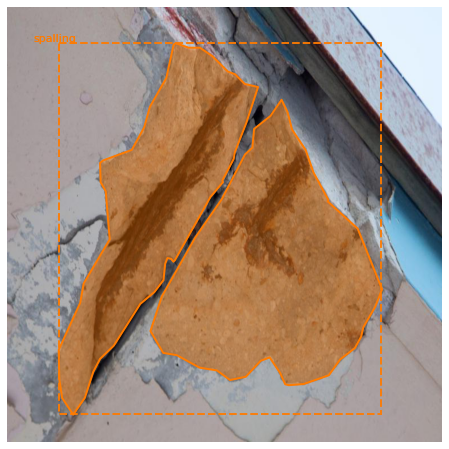

cracking0102151.jpg


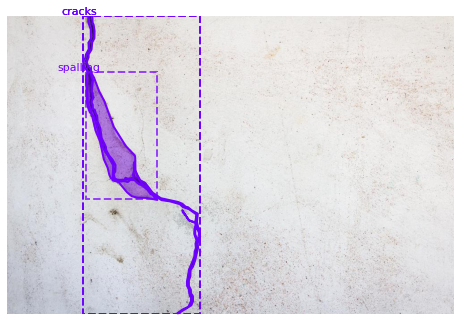

cracking274.jpg


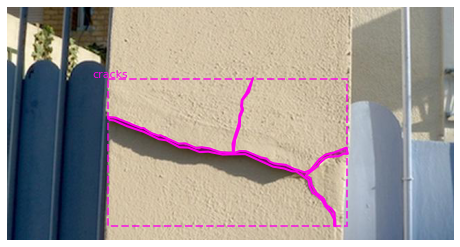

391_yang.jpg


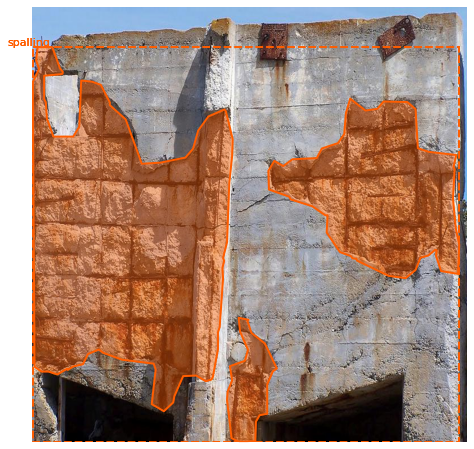

218_yang.jpg


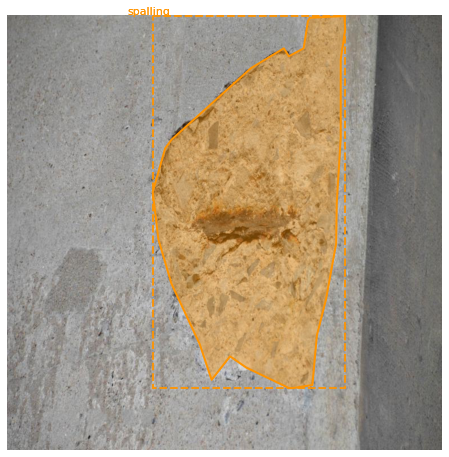

180_yang.jpg


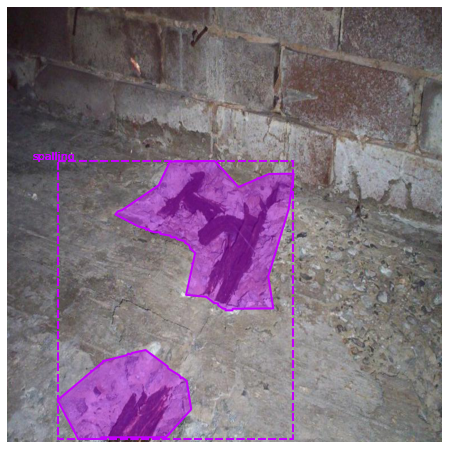

cracking0150.jpg


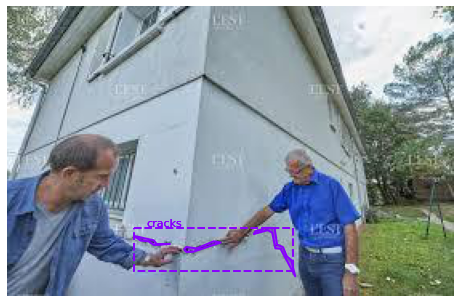

cracking348.jpg


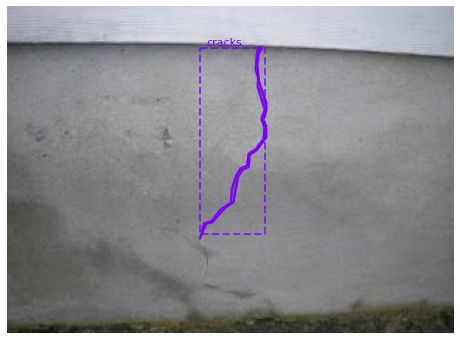

Failure-in-reinforced-concrete-walls-1.jpg


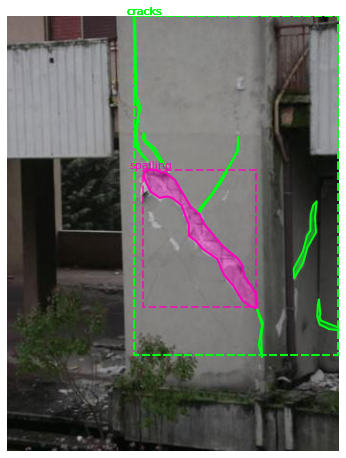

553_yang.jpg


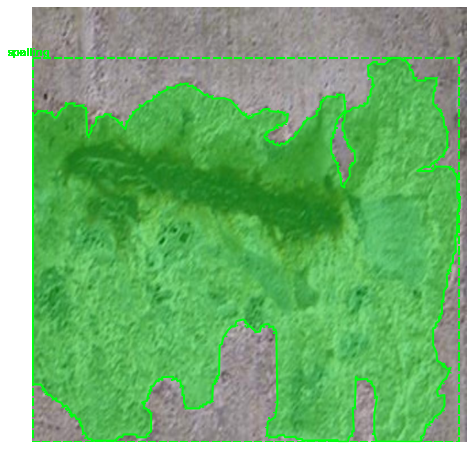

In [12]:
# User settings
subfolder = 'train'
img_list = random.choices(imgs, k=10)
pylab.rcParams['figure.figsize'] = (8,8)
####################
plot_ims_anns(img_list, subfolder, dataset_path)
